In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
file= "22-08-27/VGG16_locConnected-01:26"
df= pd.read_csv("../modelling/predictions/"+file+".csv")
#df= pd.read_csv("../modelling/predictions/22-08-26/few_slices_for_EA-17:49:46.csv")

df["Sex"].fillna(df["M/F"], inplace=True)
keep_cols = ['ID', 'Age', 'CDR_', 'label', 'Group', 'Sex', 'y_test', 'y_pred', 'y_pred_probs']
df= df[keep_cols]

df.sample(10)

,ID,Age,CDR_,label,Group,Sex,y_test,y_pred,y_pred_probs
251,014_S_0169,72,NaN,1,MCI,F,1,1,9.856718e-01
160,023_S_1104,65,NaN,1,MCI,F,1,0,1.018039e-03
123,141_S_0790,83,NaN,1,AD,F,1,1,9.999975e-01
214,094_S_0921,71,NaN,1,MCI,M,1,1,9.517724e-01
56,033_S_0734,73,NaN,0,CN,M,0,1,9.999978e-01
112,141_S_1152,71,NaN,1,AD,F,1,0,4.896147e-01
232,OAS1_0275_MR1,50,0.0,0,NaN,M,0,0,2.302775e-07
218,037_S_0566,79,NaN,1,MCI,M,1,0,6.110260e-05
211,OAS1_0296_MR1,28,0.0,0,NaN,F,0,0,2.295165e-12
263,OAS1_0125_MR1,22,0.0,0,NaN,F,0,0,6.015644e-10


In [42]:
df_o = df[df['ID'].str.contains("OAS1", case=False)]
df_a = df[df['ID'].str.contains("_S_", case=False)]

In [43]:
TP = df[(df.label == 1) & (df.y_pred == 1)]
FP = df[(df.label == 0) & (df.y_pred == 1)]
TN = df[(df.label == 0) & (df.y_pred == 0)]
FN = df[(df.label == 1) & (df.y_pred == 0)]

acc =round((TP.shape[0]+TN.shape[0])/(TP.shape[0]+FP.shape[0]+TN.shape[0]+FN.shape[0]),2)
recall= round((TP.shape[0])/(TP.shape[0]+FN.shape[0]),2)
try:
    precision= round((TP.shape[0])/(TP.shape[0]+FP.shape[0]),2)
except:
    precision = 0.0
print(f"Accuracy is {acc}, \nRecall is {recall}, \nPrecision is {precision}")

Accuracy is 0.73, 
Recall is 0.8, 
Precision is 0.74


In [44]:
def classification(row):
    if (row.label == 1) & (row .y_pred == 1):
        return "TP"
    if (row.label == 0) & (row .y_pred == 1):
        return "FP"
    if (row.label == 0) & (row .y_pred == 0):
        return "TN"
    if (row.label == 1) & (row .y_pred == 0):
        return "FN"

df["classification"] = df.apply(lambda row: classification(row), axis=1)

In [45]:
df_o["classification"] = df_o.apply(lambda row: classification(row), axis=1)
TP = df_o[(df_o.label == 1) & (df_o.y_pred == 1)]
FP = df_o[(df_o.label == 0) & (df_o.y_pred == 1)]
TN = df_o[(df_o.label == 0) & (df_o.y_pred == 0)]
FN = df_o[(df_o.label == 1) & (df_o.y_pred == 0)]

acc =round((TP.shape[0]+TN.shape[0])/(TP.shape[0]+FP.shape[0]+TN.shape[0]+FN.shape[0]),2)
recall= round((TP.shape[0])/(TP.shape[0]+FN.shape[0]),2)
try:
    precision= round((TP.shape[0])/(TP.shape[0]+FP.shape[0]),2)
except:
    precision = 0.0
print(f"Accuracy is {acc}, \nRecall is {recall}, \nPrecision is {precision}")

Accuracy is 0.83, 
Recall is 0.68, 
Precision is 0.61


/var/folders/hs/zvkng9r54wg2zhd69f8h_f280000gn/T/ipykernel_1958/2591492197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_o["classification"] = df_o.apply(lambda row: classification(row), axis=1)


In [46]:
df_a["classification"] = df_a.apply(lambda row: classification(row), axis=1)
TP = df_a[(df_a.label == 1) & (df_a.y_pred == 1)]
FP = df_a[(df_a.label == 0) & (df_a.y_pred == 1)]
TN = df_a[(df_a.label == 0) & (df_a.y_pred == 0)]
FN = df_a[(df_a.label == 1) & (df_a.y_pred == 0)]

acc =round((TP.shape[0]+TN.shape[0])/(TP.shape[0]+FP.shape[0]+TN.shape[0]+FN.shape[0]),2)
recall= round((TP.shape[0])/(TP.shape[0]+FN.shape[0]),2)
try:
    precision= round((TP.shape[0])/(TP.shape[0]+FP.shape[0]),2)
except:
    precision = 0.0
print(f"Accuracy is {acc}, \nRecall is {recall}, \nPrecision is {precision}")

Accuracy is 0.68, 
Recall is 0.82, 
Precision is 0.76


/var/folders/hs/zvkng9r54wg2zhd69f8h_f280000gn/T/ipykernel_1958/3775795882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a["classification"] = df_a.apply(lambda row: classification(row), axis=1)


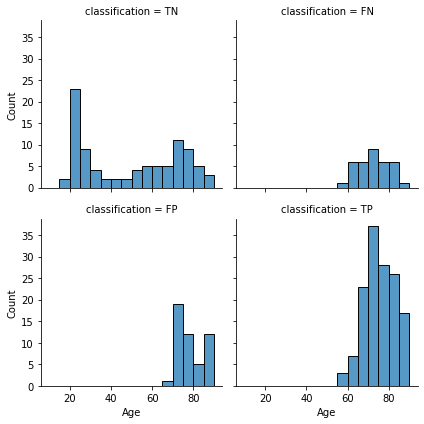

In [47]:
plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=5);

In [48]:
'''plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="CDR_", binrange=(0,3), binwidth=0.2);'''

'plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])\nplot.map_dataframe(sns.histplot, x="CDR_", binrange=(0,3), binwidth=0.2);'

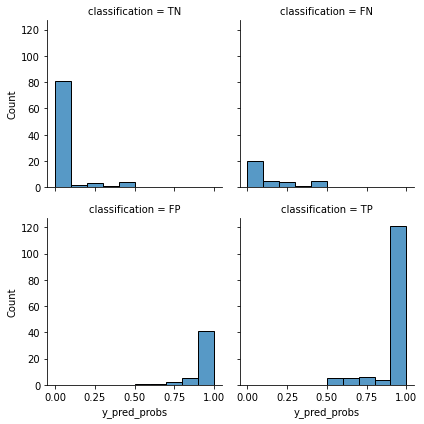

In [49]:
plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="y_pred_probs", binrange=(0,1), binwidth=0.1);

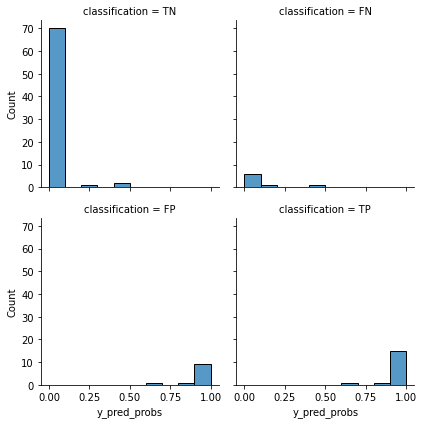

In [50]:
plot= sns.FacetGrid(data=df_o, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="y_pred_probs", binrange=(0,1), binwidth=0.1);

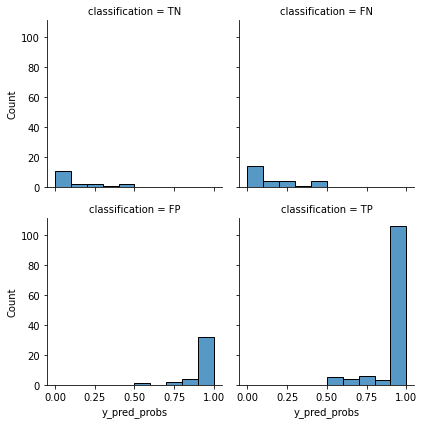

In [51]:
plot= sns.FacetGrid(data=df_a, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="y_pred_probs", binrange=(0,1), binwidth=0.1);

In [52]:
df.sort_values("y_pred_probs", inplace=True)
df= df.reset_index(drop=True)
df["order"] = df.index

In [34]:
IDs_o = df.loc[df['ID'].str.contains("OAS1", case=False)]["ID"]
IDs_a = df.loc[df['ID'].str.contains("_S_", case=False)]["ID"]

In [35]:
df_o["dataset"] ="OASIS"
df_a["dataset"] ="ADNI"
df= pd.concat([df_o, df_a], axis=0)
df.sort_values("y_pred_probs", inplace=True)

<AxesSubplot:xlabel='label', ylabel='count'>

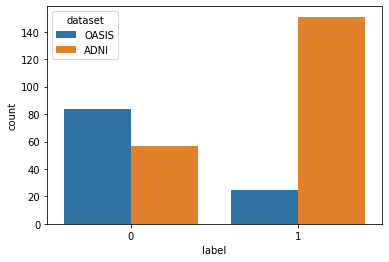

In [36]:
sns.countplot(data= df,  x="label", hue="dataset")

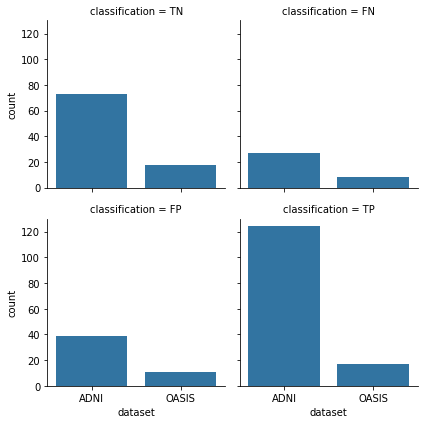

In [37]:
plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.countplot, x="dataset");

In [63]:
sys.path.append('../')
from preprocessing.getdata import *

imgs = get_slices_both(OASIS_IDs =IDs_o, ADNI_IDs =IDs_a, dim=2, m=90, normalize=True)
#imgs= get_slices(IDs_o, dim=2, m=90, normalize=False)
#imgs= get_slices_ADNI(IDs_a, dim=2, m=90, normalize=False)
imgs.shape

(317, 176, 208)

In [64]:
order= np.array(df["order"])
sort = order.argsort()
imgs_sorted= imgs[sort]

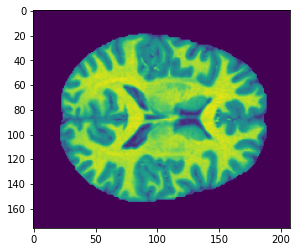

In [65]:
#most confident CN
plt.imshow(imgs_sorted[0])

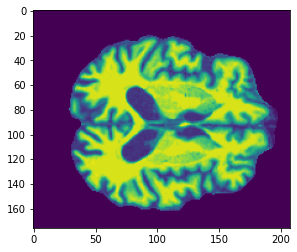

In [66]:
#most confident AD
plt.imshow(imgs_sorted[-1])

In [70]:
from matplotlib import animation


# generating gif out of slices of 3-dimensional numpy array
def generate_gif(numpy_3d_array, path="test.gif"):
    fig = plt.figure()
    im = plt.imshow(numpy_3d_array[0, :, :],    # display first slice
                    animated=True,
                    cmap='turbo',               # color mapping
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1) # highest value in numpy_3d_array
    plt.colorbar(label='turbo', shrink=0.75)
    plt.tight_layout()

    def init():
        im.set_data(numpy_3d_array[0, :, :])
        return im,

    def animate(i):
        im.set_array(numpy_3d_array[i, :, :])
        return im,

    # calling animation function of matplotlib
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=np.shape(numpy_3d_array)[0],  # amount of frames being animated
                                   interval=50,                       # update every x-milliseconds
                                   blit=True)
    anim.save(path)   # save as gif
    plt.show()

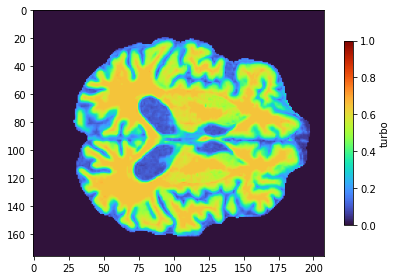

In [71]:
os.makedirs("./gifs/"+file[0:9], exist_ok=True)
generate_gif(imgs_sorted, path="./gifs/"+file+"combined_2.gif")

In [69]:
imgs_sorted.max()

1.0